In [1]:
import sys
sys.path.append('../')

import numpy as np
import random
import torch
import gpytorch
from gp_mjo.gp_mjo_model import gp_mjo
from gp_mjo.utils.dat_ops import dics_divide

from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.markers import MarkerStyle

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
npzfile = np.load('../data/mjo_new_data.npz', allow_pickle=True)

## Divide new_datas into four seasons
npz_month = npzfile['month']
winter_ids = np.where( (npz_month==12) | (npz_month==1) | (npz_month==2) )[0]
spring_ids = np.where( (npz_month==3) | (npz_month==4) | (npz_month==5) )[0]
summer_ids = np.where( (npz_month==6) | (npz_month==7) | (npz_month==8) )[0]
fall_ids = np.where( (npz_month==9) | (npz_month==10) | (npz_month==11) )[0]

print(npz_month.shape)
print(winter_ids.shape)
print(spring_ids.shape)
print(summer_ids.shape)
print(fall_ids.shape)

(16026,)
(3940,)
(4048,)
(4048,)
(3990,)


In [3]:
seasons = ['winter','spring','summer','fall']
seasons_ids = [winter_ids, spring_ids, summer_ids, fall_ids]
data_names = npzfile.files
n_files = len(npzfile.files)

season_datas = {}
for j in range(4):
    season = seasons[j]
    season_id = seasons_ids[j]

    new_datas = [0]*n_files
    for i in range(n_files):
        new_datas[i] = npzfile[data_names[i]][season_id]

    season_datas[season] = new_datas

#example
season_datas['winter']

[array([1979, 1979, 1979, ..., 2022, 2022, 2022]),
 array([1, 1, 1, ..., 2, 2, 2]),
 array([ 1,  2,  3, ..., 26, 27, 28]),
 array([ 0.142507  , -0.2042    , -0.15861   , ...,  0.28864297,
         0.42139462,  0.28795415]),
 array([ 1.05047   ,  1.37361   ,  1.53943   , ..., -0.29837567,
        -0.13990659, -0.09597149]),
 array([6., 7., 7., ..., 3., 4., 4.]),
 array([1.0600899 , 1.3887    , 1.54758   , ..., 0.41514191, 0.4440127 ,
        0.30352613])]

In [4]:
## Set initial values
widths = [40, 60, 80]
n_iter = 200
sigma_eps = 0.01
fixed_noise = True

Ns = [len(winter_ids),len(spring_ids),len(summer_ids),len(fall_ids)]# the total number of days in new dataset
n = 2500 # the number of days for training
c = 365 # the number of dropped buffer set
ms = [N-n-c for N in Ns] # the number of days for testing


n_cv = 1 # the number of operations for cross-validation
n1s  = [random.randint(0,n) for i in range(n_cv)]

## Set the kernel of GP
nu = 0.5 # 1.5,2.5.... smoothness parameter of Matern kernel
d = 1 # d = width or d = 1
kernel = gpytorch.kernels.MaternKernel(nu=nu, ard_num_dims=d) 

In [5]:
print(ms)
max_lead_time = [m + 1 - max(widths) for m in ms]
print(max_lead_time)

[1075, 1183, 1183, 1125]
[996, 1104, 1104, 1046]


In [6]:
lead_time = 60
n_pred = 2*365 # 14*365
# width + lead_time + n_pred-1 <= m

### Independent RMMs

In [7]:
# Independent
dics_total = {}
cor_total = {}
rmse_total = {}
phase_err_total = {}
amplitude_err_total = {}
for m, season in zip(ms,seasons):

    cor_n1 = {}
    rmse_n1 = {}
    phase_err_n1 = {}
    amplitude_err_n1 = {}
    for n1 in n1s:
        dics, dics_ids = dics_divide(season_datas[season], data_names, n1, m, n, c)
        dics_total[n1] = dics

        cor_width = {}
        rmse_width = {}
        phase_err_width = {}
        amplitude_err_width = {}
        for width in widths:
            mjo_model = gp_mjo(dics, dics_ids, kernel, width, n_iter, sigma_eps,fixed_noise)
            for data_name in ['RMM1','RMM2']:
                mjo_model.train_mjo(data_name)
                mjo_model.pred_mjo(data_name, lead_time, n_pred)

            # compute errors
            mjo_model.obs_extract()
            cor_width[width] = mjo_model.cor()
            rmse_width[width] = mjo_model.rmse()
            phase_err_width[width] = mjo_model.phase_err()
            amplitude_err_width[width] = mjo_model.amplitude_err()
            
        cor_n1[n1] = cor_width
        rmse_n1[n1] = rmse_width
        phase_err_n1[n1] = phase_err_width
        amplitude_err_n1[n1] = amplitude_err_width
    
    cor_total[season] = cor_n1
    rmse_total[season] = rmse_n1
    phase_err_total[season] = phase_err_n1
    amplitude_err_total[season] = amplitude_err_n1

/Users/hchen/opt/anaconda3/envs/ml/lib/python3.10/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


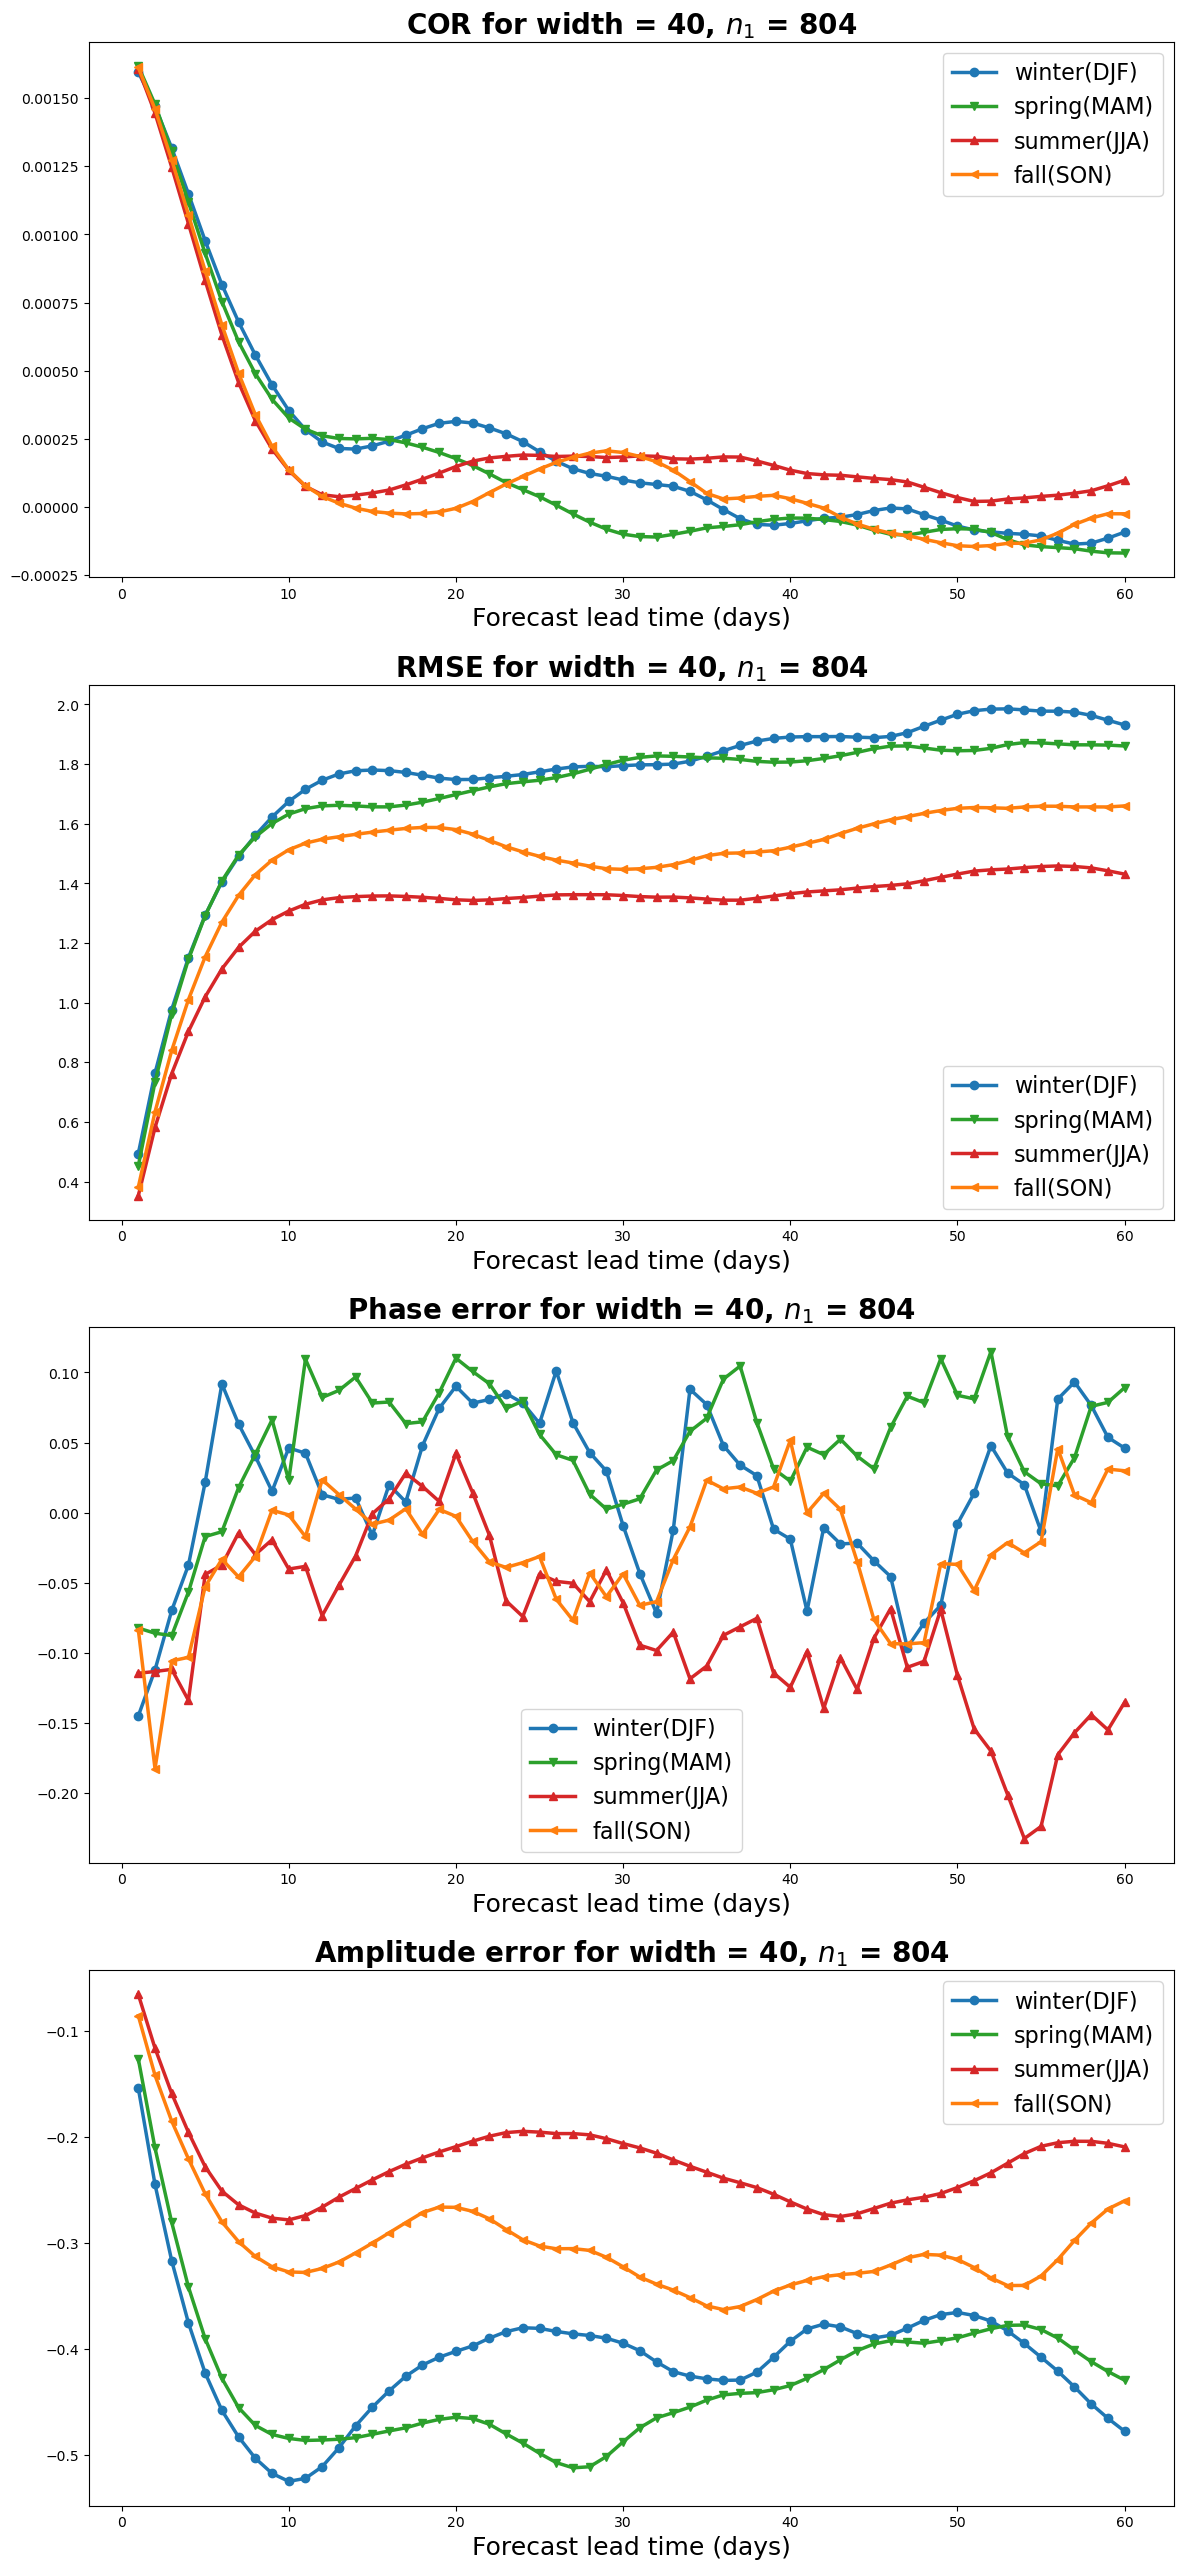

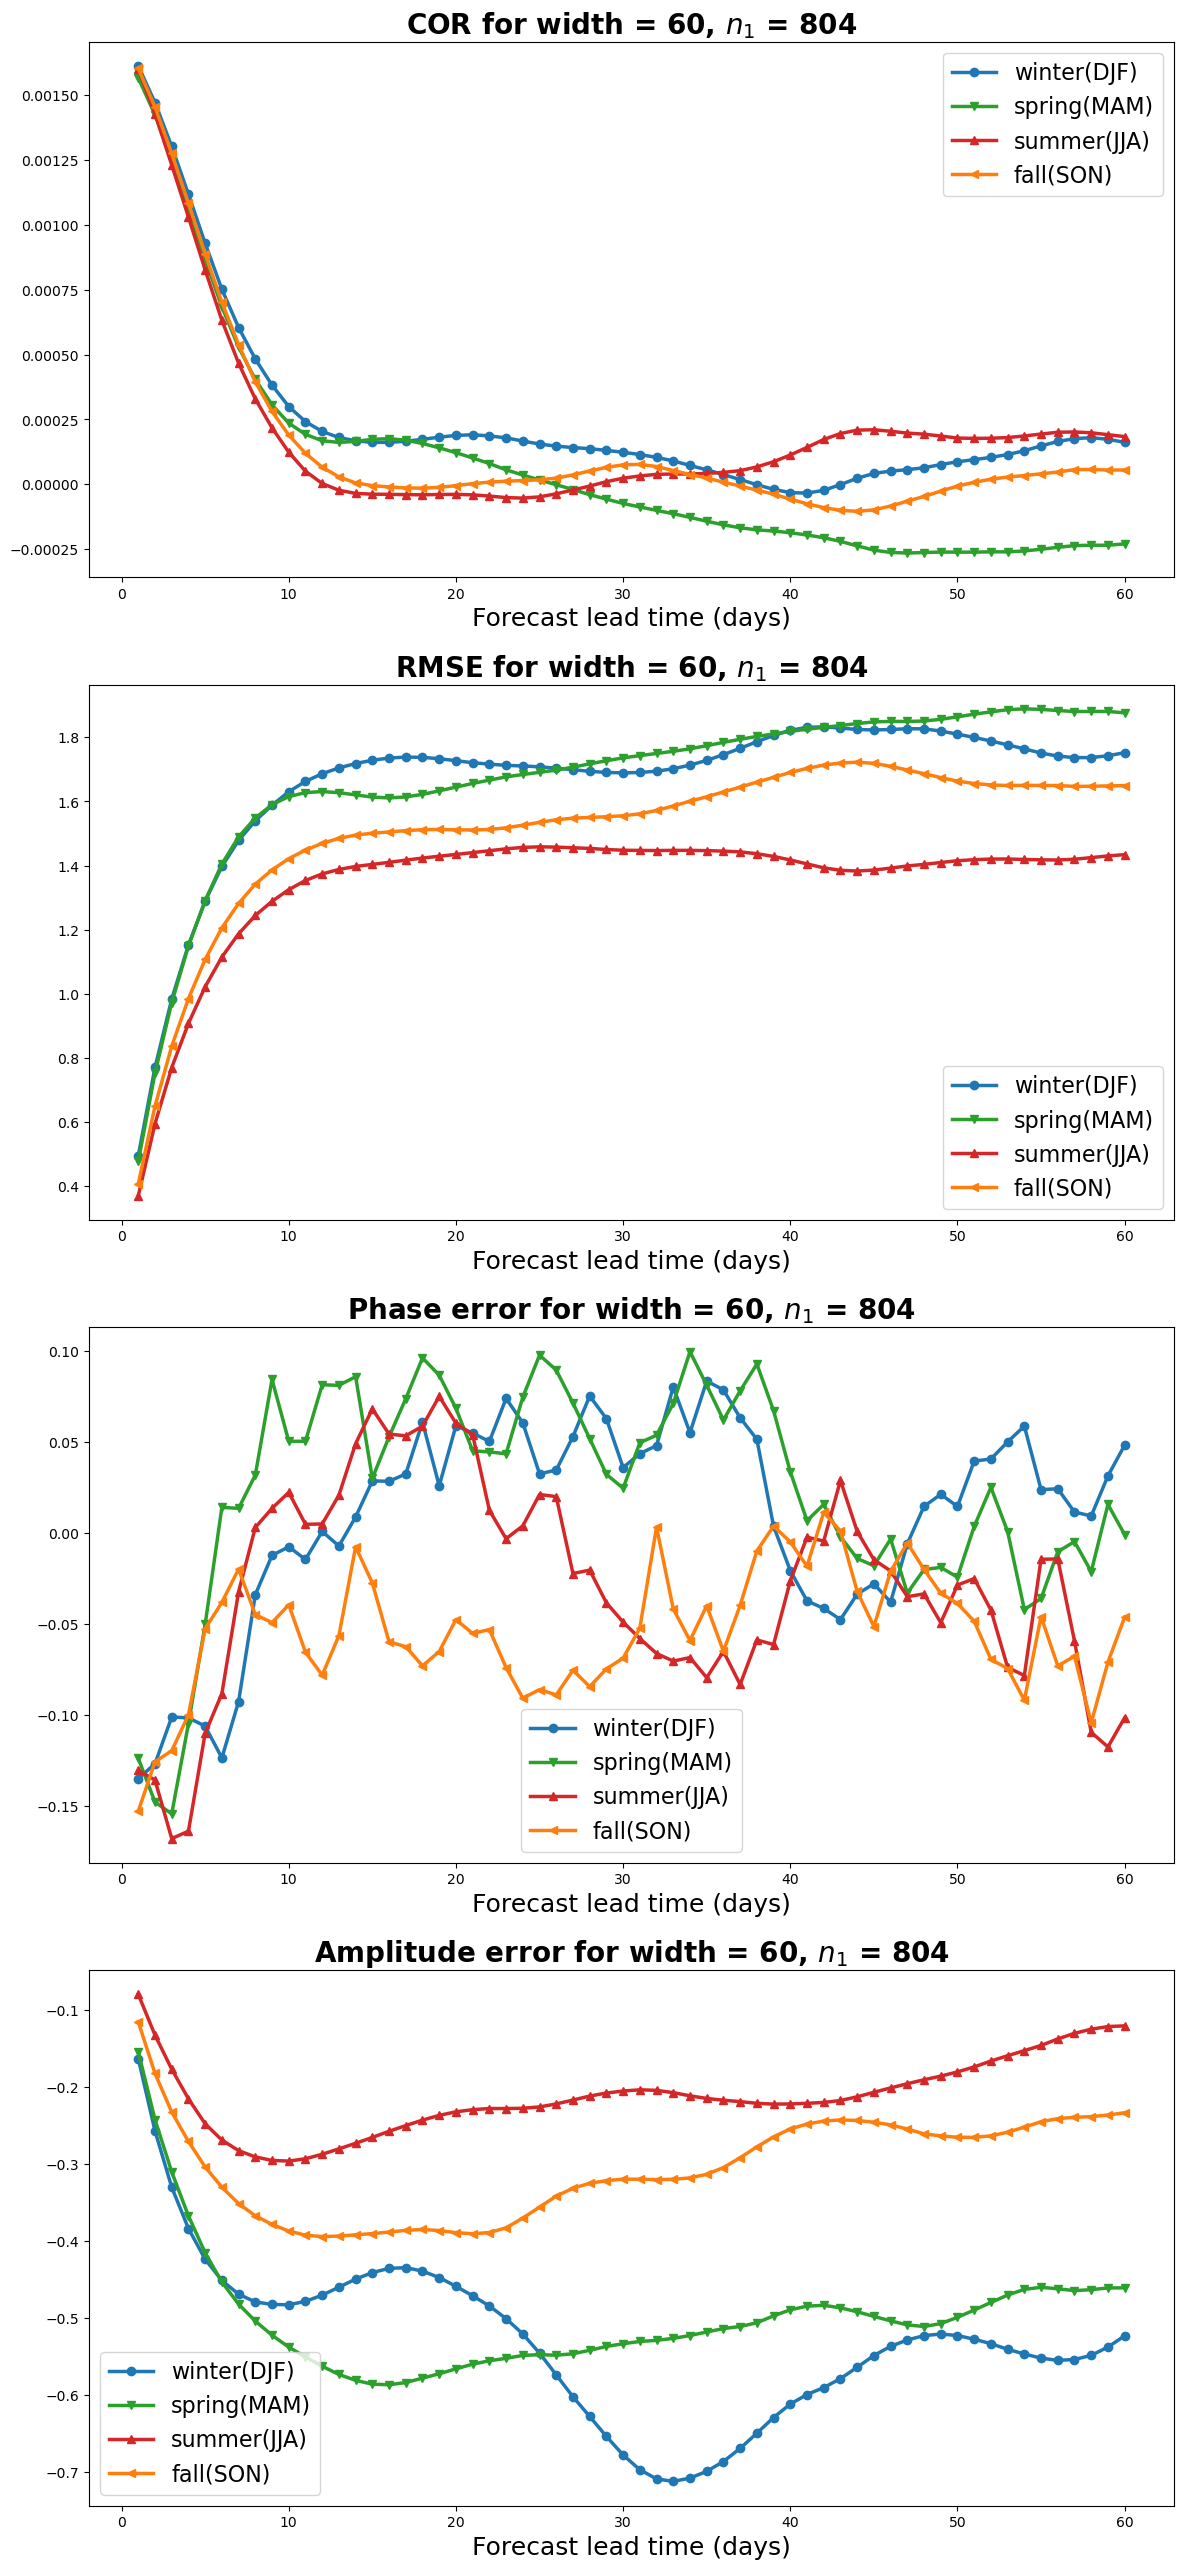

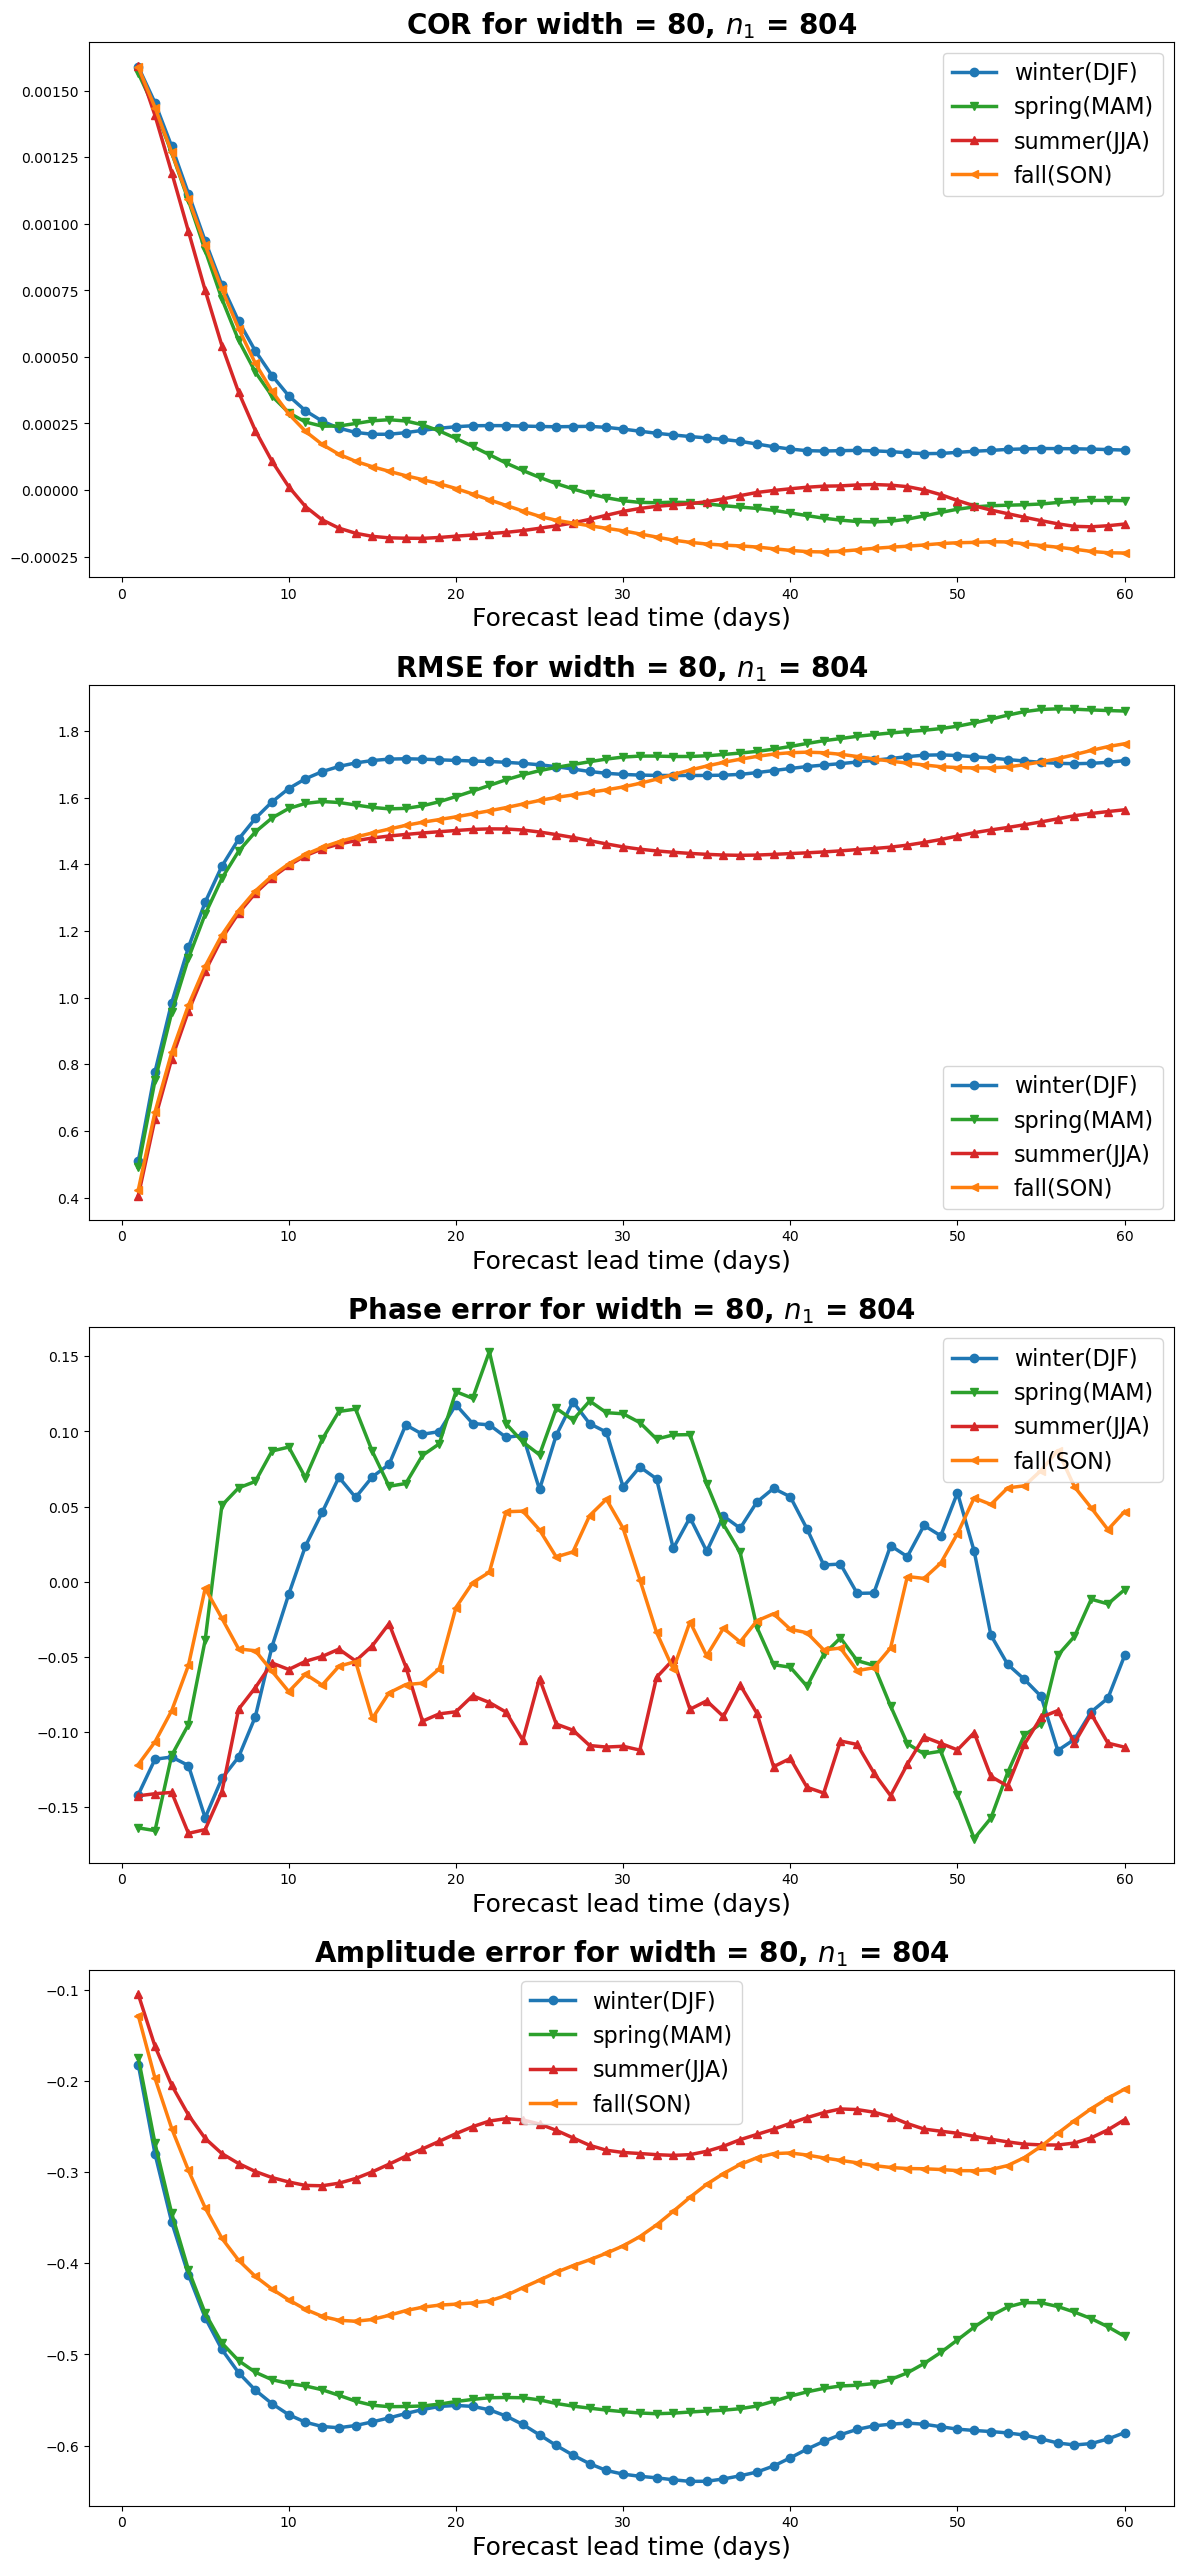

In [8]:
# Plot
palette_colors = list(mcolors.TABLEAU_COLORS.keys()) # list of Tableau Palette colors
#plot_colors = palette_colors[:len(seasons)]
plot_colors = ['tab:blue','tab:green','tab:red','tab:orange']
markers_class = list(MarkerStyle.markers.keys())
plot_markers = markers_class[2:2+len(seasons)]

season_months = ['winter(DJF)','spring(MAM)','summer(JJA)','fall(SON)']
mjo_errs = ['COR', 'RMSE', 'Phase error', 'Amplitude error']

for n1 in n1s:
    for width in widths:
        fig, axs = plt.subplots(4, 1, figsize=(14, 8*4))
        for season, color, marker in zip(seasons, plot_colors, plot_markers):
            _cor = cor_total[season][n1][width]
            _rmse = rmse_total[season][n1][width]
            _phase_err = phase_err_total[season][n1][width]
            _amplitude_err = amplitude_err_total[season][n1][width]
            
            
            axs[0].plot(np.arange(1,lead_time+1), _cor, color=color, linewidth=2.5, marker=marker)
            axs[1].plot(np.arange(1,lead_time+1), _rmse, color=color, linewidth=2.5, marker=marker)
            axs[2].plot(np.arange(1,lead_time+1), _phase_err, color=color, linewidth=2.5, marker=marker)
            axs[3].plot(np.arange(1,lead_time+1), _amplitude_err, color=color, linewidth=2.5, marker=marker)

        for i, mjo_err in enumerate(mjo_errs):
            axs[i].set_xlabel('Forecast lead time (days)', fontsize=18)
            axs[i].legend(season_months, fontsize=16)
            axs[i].set_title(f'{mjo_err} for width = {width}, $n_1$ = {n1} with Independent RMMs', fontsize=20, fontweight="bold")

### Dependent RMMs

In [9]:
# Dependent
dics_total = {}
cor_total = {}
rmse_total = {}
phase_err_total = {}
amplitude_err_total = {}
for m, season in zip(ms,seasons):

    cor_n1 = {}
    rmse_n1 = {}
    phase_err_n1 = {}
    amplitude_err_n1 = {}
    for n1 in n1s:
        dics, dics_ids = dics_divide(season_datas[season], data_names, n1, m, n, c)
        dics_total[n1] = dics

        cor_width = {}
        rmse_width = {}
        phase_err_width = {}
        amplitude_err_width = {}
        for width in widths:
            mjo_model = gp_mjo(dics, dics_ids, kernel, width, n_iter, sigma_eps,fixed_noise)
            mjo_model.train_mjo(Depend=True)
            for data_name in ['RMM1','RMM2']:    
                mjo_model.pred_mjo(data_name, lead_time, n_pred)

            # compute errors
            mjo_model.obs_extract()
            cor_width[width] = mjo_model.cor()
            rmse_width[width] = mjo_model.rmse()
            phase_err_width[width] = mjo_model.phase_err()
            amplitude_err_width[width] = mjo_model.amplitude_err()
            
        cor_n1[n1] = cor_width
        rmse_n1[n1] = rmse_width
        phase_err_n1[n1] = phase_err_width
        amplitude_err_n1[n1] = amplitude_err_width
    
    cor_total[season] = cor_n1
    rmse_total[season] = rmse_n1
    phase_err_total[season] = phase_err_n1
    amplitude_err_total[season] = amplitude_err_n1

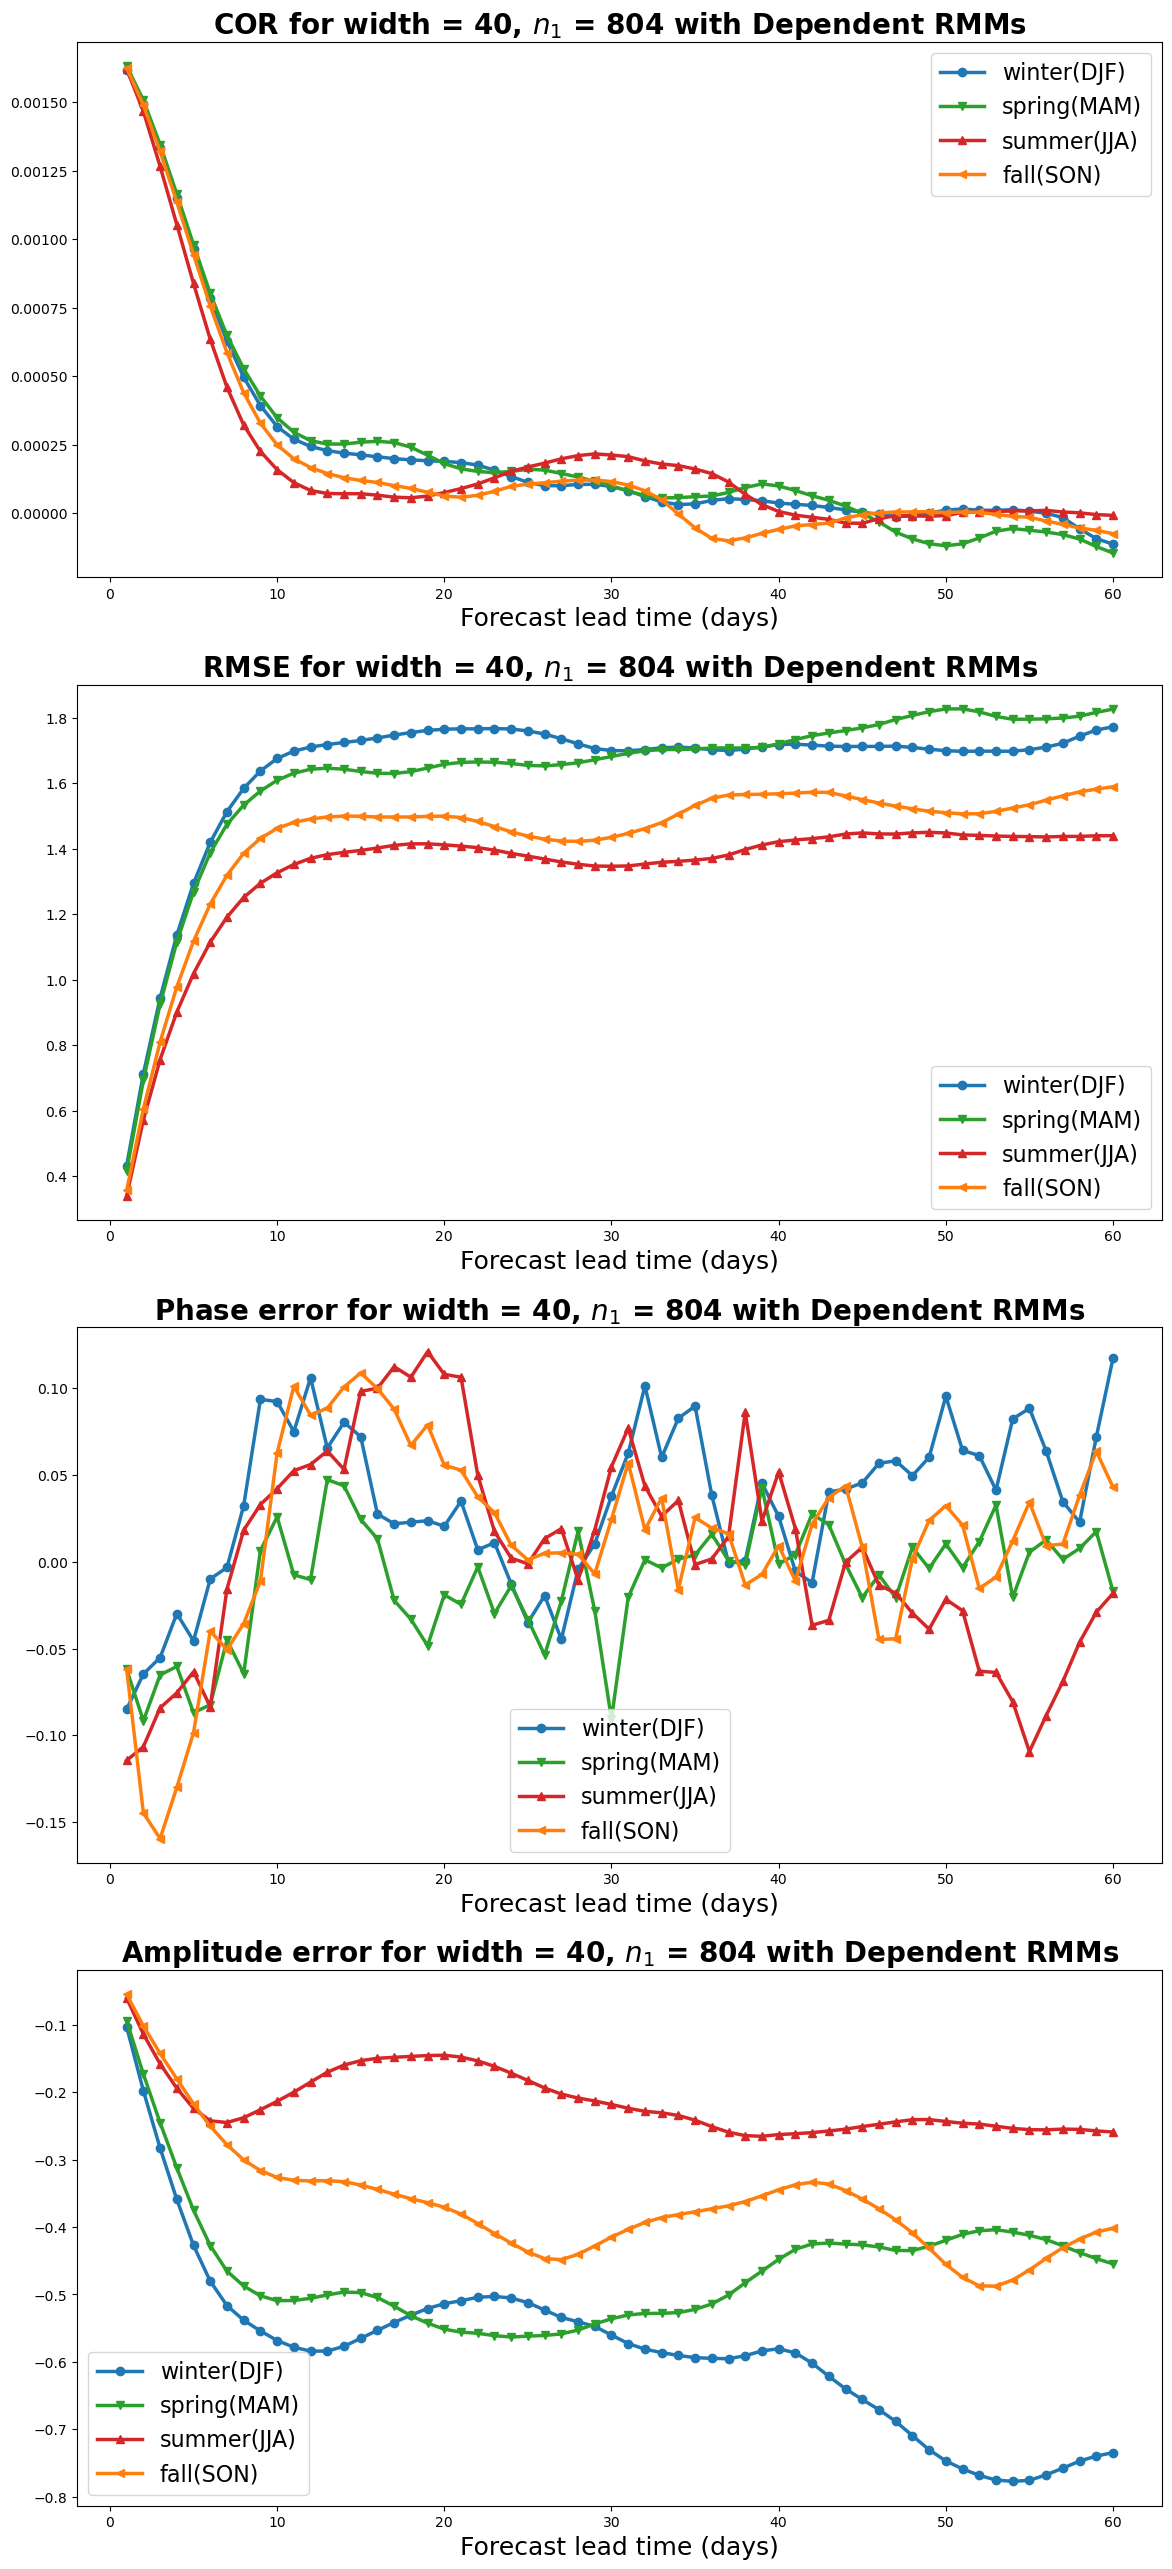

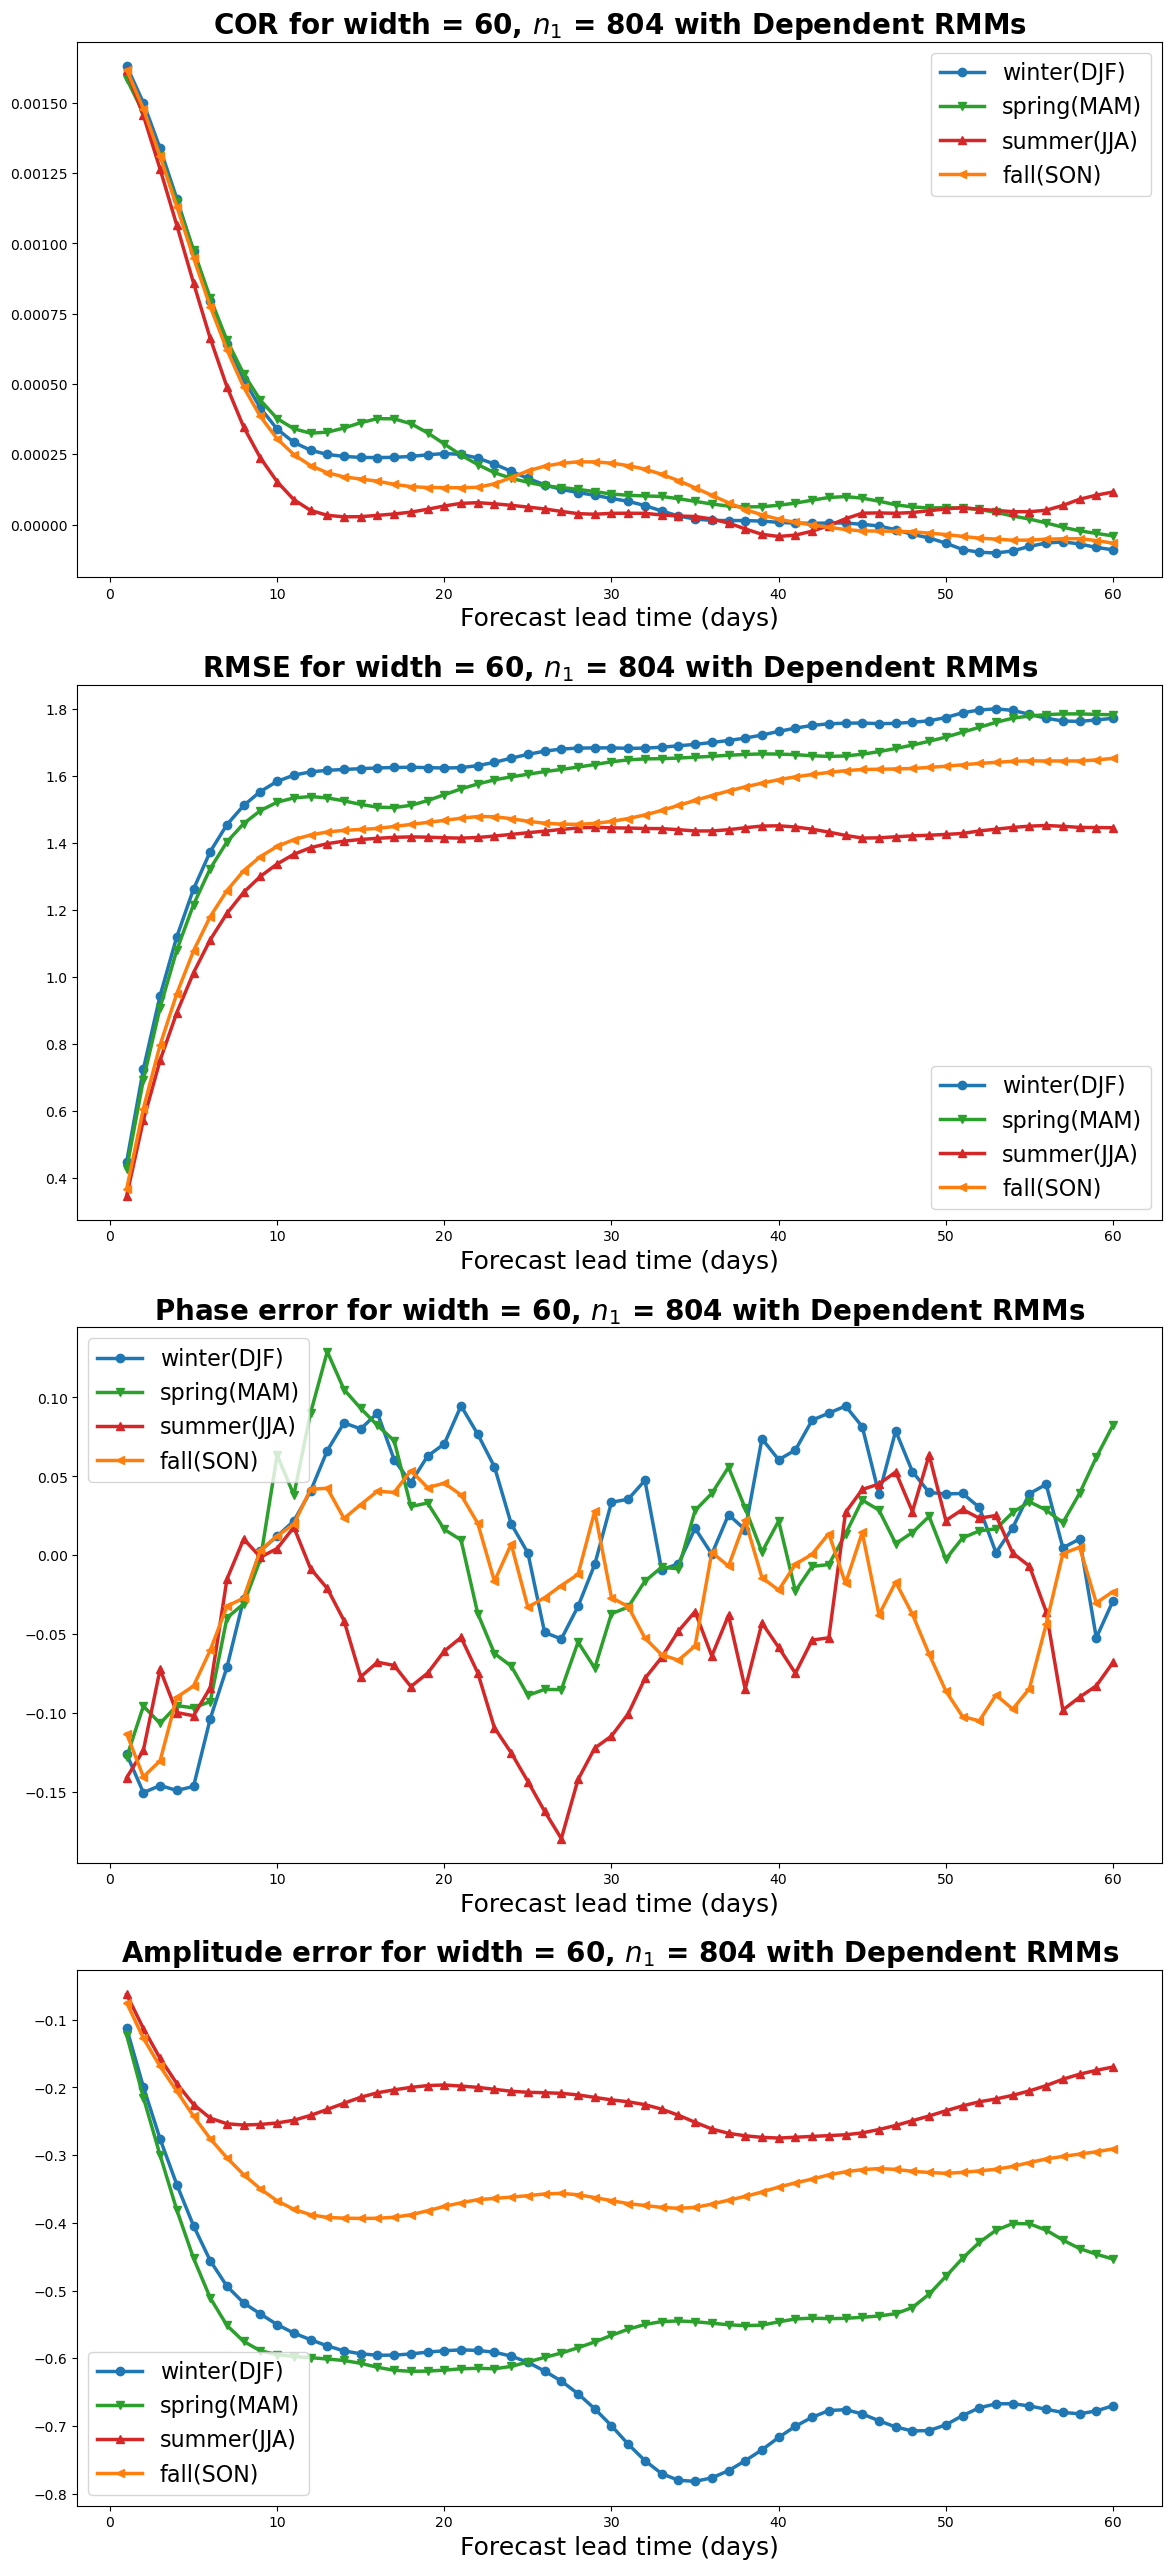

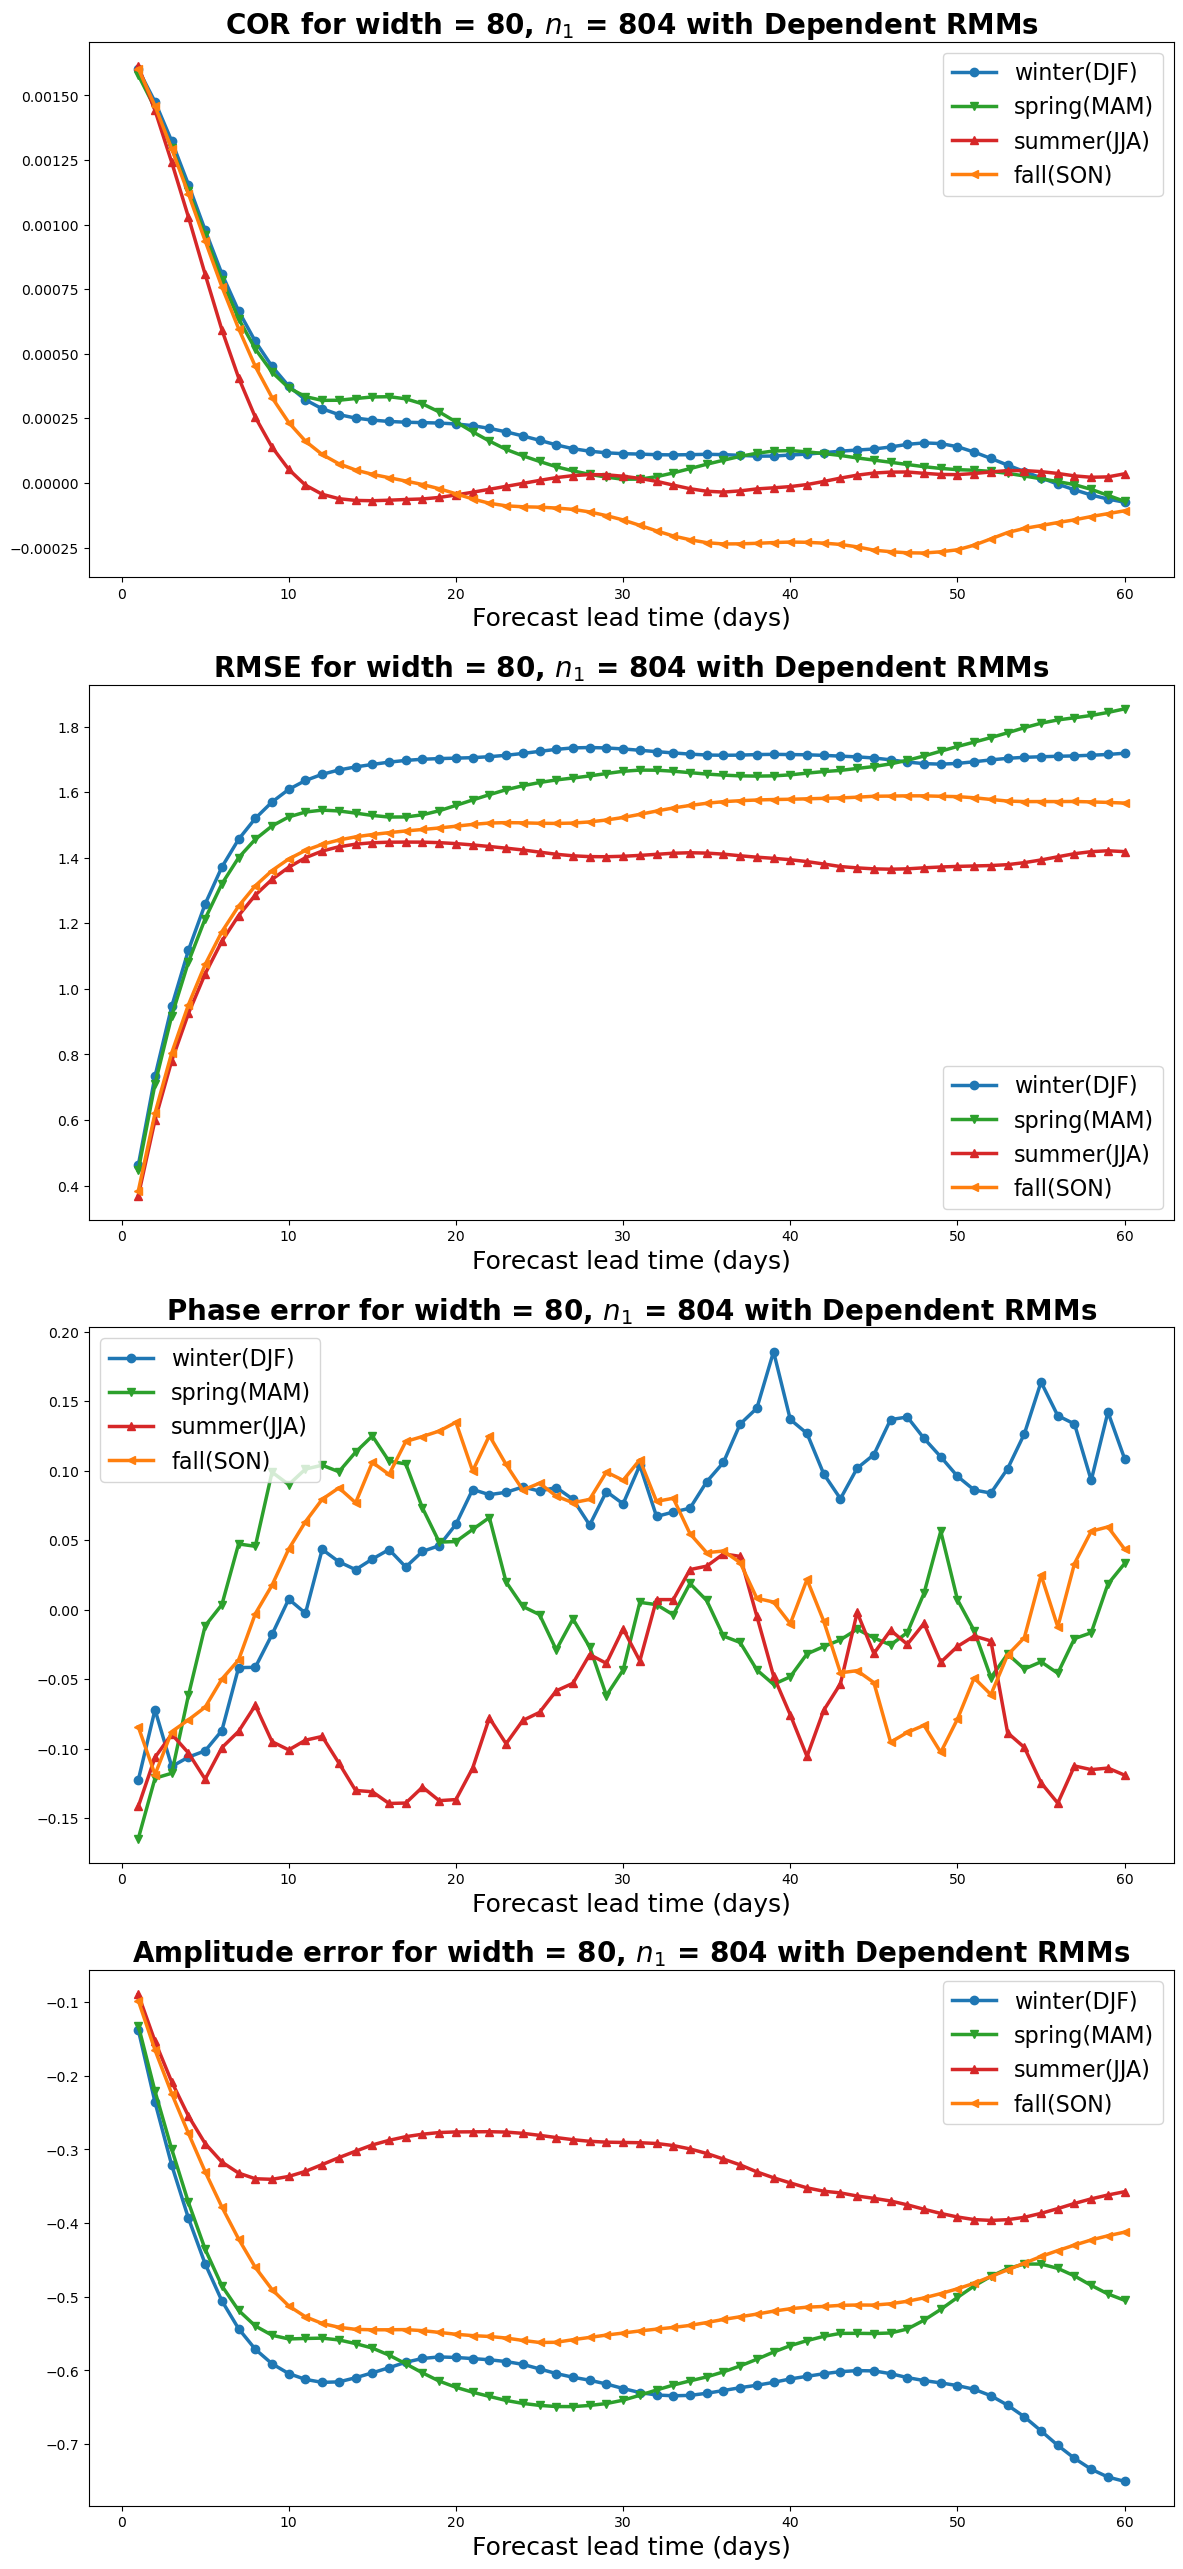

In [10]:
# Plot
palette_colors = list(mcolors.TABLEAU_COLORS.keys()) # list of Tableau Palette colors
#plot_colors = palette_colors[:len(seasons)]
plot_colors = ['tab:blue','tab:green','tab:red','tab:orange']
markers_class = list(MarkerStyle.markers.keys())
plot_markers = markers_class[2:2+len(seasons)]

season_months = ['winter(DJF)','spring(MAM)','summer(JJA)','fall(SON)']
mjo_errs = ['COR', 'RMSE', 'Phase error', 'Amplitude error']

for n1 in n1s:
    for width in widths:
        fig, axs = plt.subplots(4, 1, figsize=(14, 8*4))
        for season, color, marker in zip(seasons, plot_colors, plot_markers):
            _cor = cor_total[season][n1][width]
            _rmse = rmse_total[season][n1][width]
            _phase_err = phase_err_total[season][n1][width]
            _amplitude_err = amplitude_err_total[season][n1][width]
            
            
            axs[0].plot(np.arange(1,lead_time+1), _cor, color=color, linewidth=2.5, marker=marker)
            axs[1].plot(np.arange(1,lead_time+1), _rmse, color=color, linewidth=2.5, marker=marker)
            axs[2].plot(np.arange(1,lead_time+1), _phase_err, color=color, linewidth=2.5, marker=marker)
            axs[3].plot(np.arange(1,lead_time+1), _amplitude_err, color=color, linewidth=2.5, marker=marker)

        for i, mjo_err in enumerate(mjo_errs):
            axs[i].set_xlabel('Forecast lead time (days)', fontsize=18)
            axs[i].legend(season_months, fontsize=16)
            axs[i].set_title(f'{mjo_err} for width = {width}, $n_1$ = {n1} with Dependent RMMs', fontsize=20, fontweight="bold")